In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import fu, nu
from datetime import date, timedelta
from pandas import DataFrame, to_datetime, Series
import numpy as np
import os
import os.path as osp
from IPython.display import HTML
import pandas as pd

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='', count_swaps_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 367627 290 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 290 290 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 420 290 48
count_swaps_df = data_frames_dict['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 289 289 3

triage_paper_df 367627 290 111
file_stats_df 290 290 19
scene_stats_df 420 290 48
count_swaps_df 315 289 3


In [4]:

columns_list = ['injury_severity', 'patient_salt']
mask_series = (triage_paper_df.patient_id == 'Gloria_8 Root')
df = DataFrame([
    {'injury_severity': patient_df.injury_severity.min(), 'patient_salt': patient_df.patient_salt.max()} for _, patient_df in triage_paper_df[mask_series].groupby(
        fu.patient_groupby_columns
    )
])
display(df[columns_list].drop_duplicates().sort_values(columns_list))

,injury_severity,patient_salt
0,low,DELAYED
1,low,MINIMAL
89,NaN,MINIMAL
52,NaN,NaN


In [5]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=[
        'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category', 'file_name', 'session_file_name',
        'encounter_layout'
    ],
    patient_count_filter_fn=None
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 121

elevens_df 365543 289 120


In [6]:

print()
count_swaps_df.swaps_to_perfect_order_count.value_counts().sort_index()

0     79
1    137
2     46
3     47
4      2
5      4
Name: swaps_to_perfect_order_count, dtype: int64

In [7]:

# Get a dataset of only first11 patients
nongrouped_patients_list = nu.load_object('nongrouped_patients_list')
mask_series = ~elevens_df.patient_id.isin(nongrouped_patients_list)
elevens_df = elevens_df[mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 390108 331 121

elevens_df 365521 289 120


In [8]:

# Get a dataset of only "First 11" encounter layouts
mask_series = (elevens_df.encounter_layout == 'DCEMS 11')
display(elevens_df.groupby('encounter_layout').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))
elevens_df = elevens_df[~mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 367025 295 119

,record_count
encounter_layout,
First 11,365238


elevens_df 365521 289 120


In [9]:

# for the "Other" label, instead, put back whether they were Faculty or something else (Nurse, etc.)
mask_series = (elevens_df.responder_category == 'Other')
elevens_df.loc[mask_series, 'responder_category'] = elevens_df.loc[mask_series, 'overall_category']


## For the requests below only use n = 324 (filter out 4 faculty, 1 nurse, and Other HP from this analysis). The remaining n should breakdown should be as follows:
 - EMT-Paramedic = 224
 - EMT-Basic = 23
 - EM-Resident = 32
 - Medical Student = 45

In [10]:

print(f'n = {elevens_df.session_uuid.nunique()}')
FILTERED_CATEGORIES_LIST = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
mask_series = ~elevens_df.responder_category.isnull()
CATEGORY_DICT = {responder_category: responder_category for responder_category in elevens_df[mask_series].responder_category}
CATEGORY_DICT.update({'Paramedic': 'EMT-Paramedic', 'EM Resident': 'EM-Resident'})
mask_series = elevens_df.responder_category.isin(list(CATEGORY_DICT.keys()))
gb = elevens_df[mask_series].groupby('responder_category')
tuples_list = [(CATEGORY_DICT[responder_category], '=', df.session_uuid.nunique()) for responder_category, df in gb]
category_order = [CATEGORY_DICT[c] for c in FILTERED_CATEGORIES_LIST] + ['EM-Faculty', 'Nurse', 'Other HP']
for category_tuple in sorted(tuples_list, key=lambda x: category_order.index(x[0])): print(*category_tuple)

n = 289
EMT-Paramedic = 191
EMT-Basic = 19
EM-Resident = 32
Medical Student = 40
EM-Faculty = 4
Nurse = 1
Other HP = 1


In [11]:

# Replace any PATIENT_RECORD designation with OSU’s spreadsheet designation
import re

first11_optimal_order_df = nu.load_object('first11_optimal_order_df')
search_regex = re.compile('^(' + '|'.join(first11_optimal_order_df.SALT.map(lambda x: str(x).upper()).unique()) + ')$')
columns_list = nu.get_regexed_columns(elevens_df, search_regex=search_regex)
for (patient_id, patient_salt), patient_salt_df in first11_optimal_order_df.groupby(['Patient', 'SALT']):
    # print(patient_id, patient_salt.upper())
    mask_series = (elevens_df.patient_id == patient_id)
    for cn in columns_list: elevens_df.loc[mask_series, cn] = patient_salt.upper()


## boxplots for 4 measures (time to triage accuracy, time to triage scene, hemorrhage control for all life-threatening bleeding, hemorrhage control for all life-threatening bleeding per patient)

In [12]:

# Get whisker plot for various measures
import seaborn as sns
import matplotlib.pyplot as plt
from random import uniform  # for jitter

temporalize_fn = lambda x: fu.format_timedelta(timedelta(milliseconds=int(x)), minimum_unit='minutes')
def get_plot_dataframe(
    y_column_name, scene_fn, logs_df=elevens_df, x_column_name='responder_category', responder_categories_list=FILTERED_CATEGORIES_LIST, verbose=False
):
    '''
    The order and labeling should be (from left to right):
        EMT-Paramedic
        EMT-Basic
        EM-Resident
        Medical Student
    '''
    rows_list = []
    for responder_category in responder_categories_list:
        if verbose: print('responder_category:', responder_category)
        mask_series = (logs_df[x_column_name] == responder_category)
        responder_categories_df = logs_df[mask_series]
        gb = responder_categories_df.groupby(fu.scene_groupby_columns)
        for (session_uuid, scene_id), scene_df in gb:
            row_dict = {}
            if 'session_uuid' in scene_df.columns: row_dict['session_uuid'] = session_uuid
            if 'scene_id' in scene_df.columns: row_dict['scene_id'] = scene_id
            row_dict[x_column_name] = responder_category
            row_dict[y_column_name] = scene_fn(scene_df)
            row_dict['scene_count'] = gb.size().shape[0]
            rows_list.append(row_dict)
    df = DataFrame(rows_list)
    
    return df

In [13]:

def adjust_plot(ax, x_label, y_label, responder_categories_list, ytick_fn=temporalize_fn):
    
    # Rotate the x-axis labels to prevent overlapping
    plt.xticks(rotation=45)

    # Label the x- and y-axis
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    # Humanize y tick labels
    locs, labels = plt.yticks()
    yticklabels_list = []
    for ytick_value, text_obj in zip(locs, labels):
        text_obj.set_text(ytick_fn(ytick_value))
        yticklabels_list.append(text_obj)
    plt.yticks(locs[1:], yticklabels_list[1:])

    # Re-label x tick labels
    locs, labels = plt.xticks()
    xticklabels_list = []
    for idx, text_obj in zip(locs, labels):
        text_obj.set_text(CATEGORY_DICT[responder_categories_list[idx]])
        xticklabels_list.append(text_obj)
    plt.xticks(locs, xticklabels_list)

In [14]:

def show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, print_responder_counts=False, verbose=False):
    df = get_plot_dataframe(y_column_name, scene_fn, logs_df=logs_df, verbose=verbose)
    x_column_name = 'responder_category'
    x_label = ' '.join([w.title() for w in x_column_name.split('_')])

    # Create a figure and subplots
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))

    # Create a box plot under the scatter plot; put a black square for the mean instead
    ax = sns.boxplot(
        ax=ax,
        data=df,
        fliersize=0.0,
        meanprops={'marker': 's', 'markerfacecolor': 'black', 'markeredgecolor': 'black', 'markersize': 8},
        showmeans=True,
        x=x_column_name,
        y=y_column_name,
    )

    # Jitter amount
    jitter_amt = 0.1  # Adjust this value to control jitter range

    # Add jittered points
    sns.stripplot(
        alpha=0.25,  # Adjust transparency
        ax=ax,
        color='black',
        data=df,
        jitter=jitter_amt,  # Add jitter
        s=6,  # Adjust marker size
        x=x_column_name,
        y=y_column_name,
    )
    
    adjust_plot(ax, x_label, y_label, FILTERED_CATEGORIES_LIST, ytick_fn)
    plt.show()

In [15]:

file_path = '../data/xlsx/anova290_df_Apr24_Final.xlsx'
anova_apr24_final_df = pd.read_excel(file_path)

In [16]:

# anova_apr24_final_df.Group.unique().tolist()
groups_list = ['Paramedic', 'EMT-Basic', 'EM Resident', 'Medical Student']
mask_series = anova_apr24_final_df.Group.isin(groups_list)
anova_df = anova_apr24_final_df[mask_series]

In [17]:

mask_series = elevens_df.responder_category.isin(groups_list)
elevens_df = elevens_df[mask_series]


## The y-axis labels should be as follows:


 - Triage Tag Accuracy

In [18]:

# Create the tag-to-SALT data frame
assert len(set(elevens_df.columns).intersection(set(fu.patient_groupby_columns))) == 3, "You don't have all the patient columns"
tag_to_salt_df = fu.get_is_tag_correct_data_frame(elevens_df, groupby_column='responder_category')

In [19]:

# Show the tag predictions of Gloria 8
mask_series = tag_to_salt_df.patient_id.map(lambda x: str(x).startswith('Gloria_8'))
columns_list = ['last_tag', 'max_salt', 'predicted_tag', 'is_tag_correct']
df = tag_to_salt_df[mask_series][columns_list]
# df.drop_duplicates()
df = df.groupby(['predicted_tag', 'is_tag_correct']).size().reset_index(drop=False).rename(columns={0: 'record_count'})
mask_series = df.predicted_tag.isin(['yellow', 'green'])
df[mask_series]

,predicted_tag,is_tag_correct,record_count
6,yellow,False,0
7,yellow,True,0
8,green,False,106
9,green,True,179


In [20]:

# Get the percentage tag correct counts for each scene for each group
percentage_tag_correct_df = fu.get_percentage_tag_correct_data_frame(tag_to_salt_df, groupby_column='responder_category')

In [24]:

remove_mask_series = (percentage_tag_correct_df.percentage_tag_correct == 0)
session_uuids_list = percentage_tag_correct_df[remove_mask_series].session_uuid
mask_series = percentage_tag_correct_df.session_uuid.isin(session_uuids_list)
display(percentage_tag_correct_df[mask_series])
percentage_tag_correct_df = percentage_tag_correct_df[~remove_mask_series]

,session_uuid,scene_id,responder_category,percentage_tag_correct
36,1e7d274d-f393-4888-9f28-4de53b0260e3,0,Paramedic,0.000000
37,1e7d274d-f393-4888-9f28-4de53b0260e3,1,Paramedic,72.727273
171,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,0,Medical Student,0.000000
172,9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13,1,Medical Student,36.363636
185,a7804ee3-6a1c-4462-957a-17976a540483,0,EM Resident,0.000000
186,a7804ee3-6a1c-4462-957a-17976a540483,1,EM Resident,81.818182


In [25]:

percentage_tag_correct_df.sort_values('percentage_tag_correct')

,session_uuid,scene_id,responder_category,percentage_tag_correct
59,30a49dd8-c08a-4994-a622-57647670b5bb,0,Paramedic,9.090909
98,52e2653e-2230-4d8a-929b-e2a12dcb56c4,0,Paramedic,27.272727
55,2d26ca7b-1dbb-42e4-9bbf-bf0d131e2e06,0,Medical Student,27.272727
74,38b995b3-fb77-4fda-b0b4-21f062ed6a38,0,Medical Student,27.272727
45,22e2c9a3-b93f-4f7f-896a-ca188c78505b,0,Medical Student,36.363636
...,...,...,...,...
76,3ce991bc-a2d1-46fd-a3a4-d3611e946ed7,0,Paramedic,100.000000
223,d1445846-942b-422f-86ae-8b2a0b6133a8,0,Paramedic,100.000000
224,d2c676e2-fddc-4872-9a26-b621d6585df9,0,Paramedic,100.000000
42,2107820d-d55c-40bb-bb90-6b10c227664c,0,Paramedic,100.000000


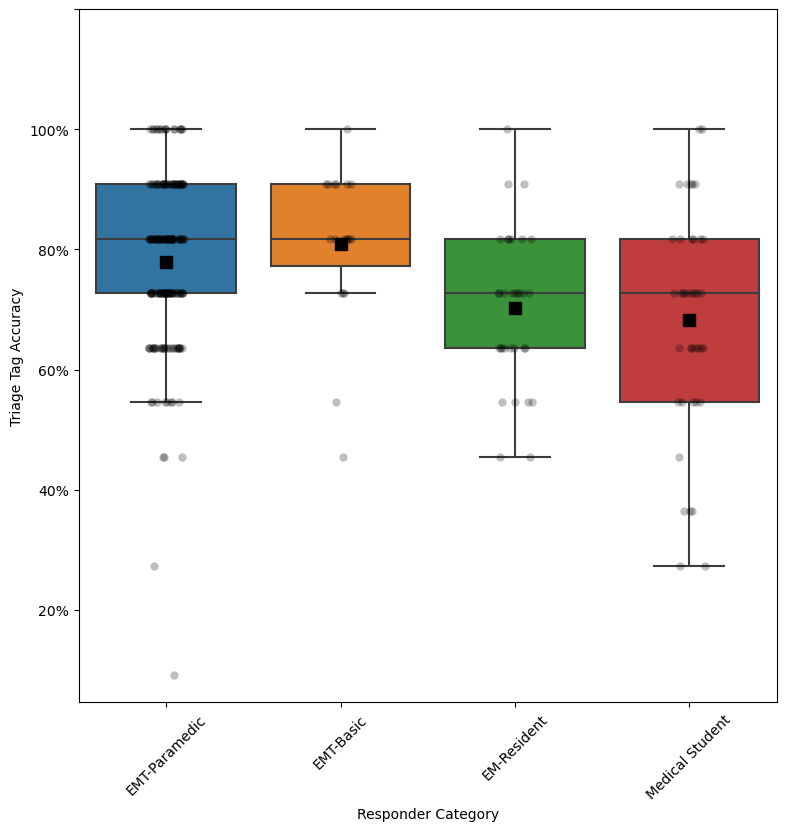

In [26]:

y_column_name = 'percentage_tag_correct'
y_label = 'Triage Tag Accuracy'
scene_fn = lambda scene_df: scene_df[y_column_name].mean()
percents_fn = lambda x: f'{int(x)}%' if (x<=100) else ''
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=percents_fn, logs_df=percentage_tag_correct_df, verbose=False)


 - Time to Triage Scene

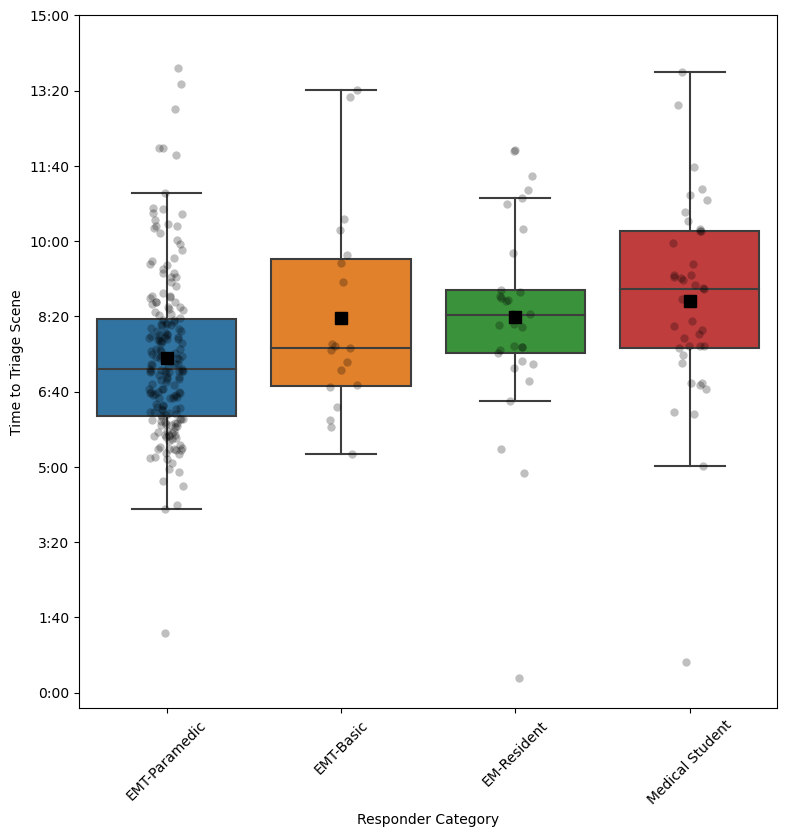

In [27]:

y_column_name = 'triage_time'
y_label = 'Time to Triage Scene'
scene_fn = lambda scene_df: fu.get_triage_time(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, ytick_fn=temporalize_fn, logs_df=elevens_df, verbose=False)


 - Hemorrhage Control for all Life-threatening Bleeding (if that doesnt fit, just do Hemorrhage Control)

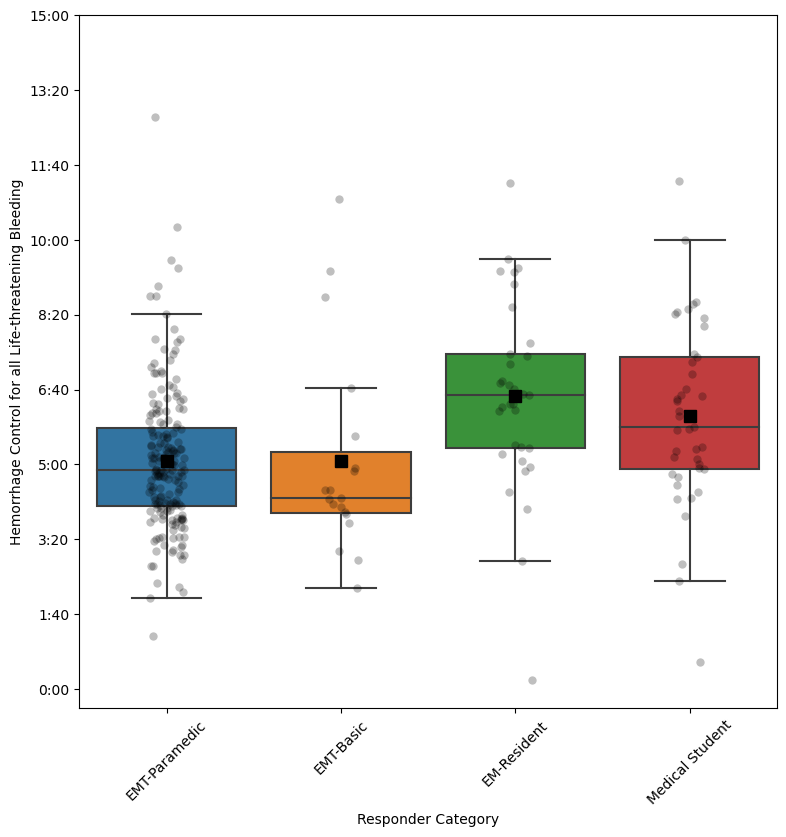

In [28]:

y_column_name = 'time_to_last_hemorrhage_controlled'
y_label = 'Hemorrhage Control for all Life-threatening Bleeding'
scene_fn = lambda scene_df: fu.get_time_to_last_hemorrhage_controlled(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


 - Hemorrhage Control per Patient

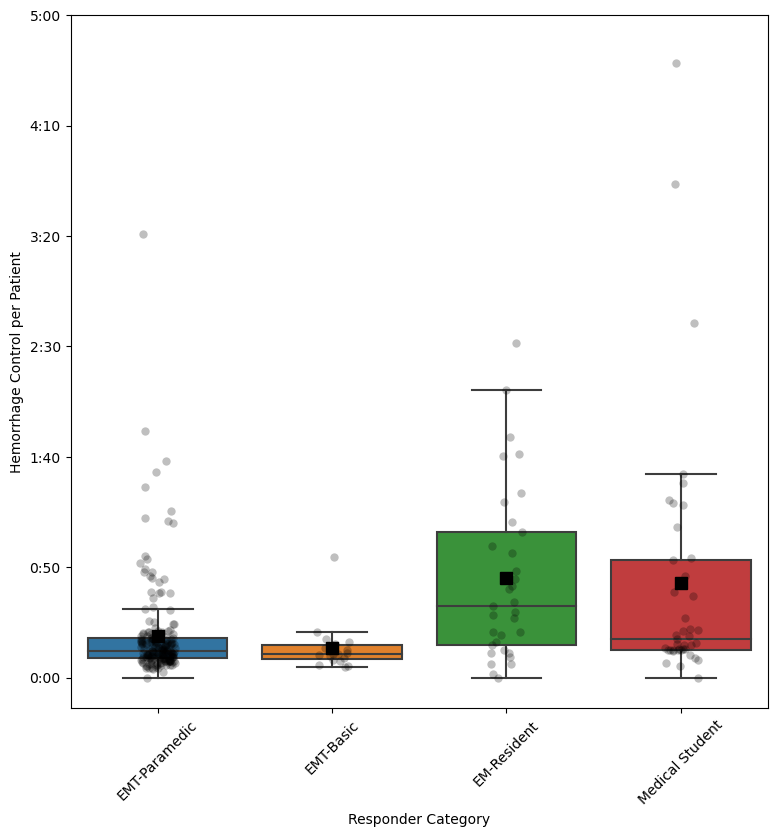

In [29]:

# Duration of time from when the patient was first approached by the participant until
# the time hemorrhage treatment was applied (with a tourniquet or wound packing)
y_column_name = 'time_to_hemorrhage_control'
y_label = 'Hemorrhage Control per Patient'
scene_fn = lambda scene_df: fu.get_time_to_hemorrhage_control_per_patient(scene_df)
show_whisker_plot(y_column_name, y_label, scene_fn, temporalize_fn)


## Stacked graph for triage errors

In [30]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['last_tag', 'max_salt', 'responder_category']
error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
error_types_df['error_type'] = error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
error_types_df['last_tag'] = error_types_df['last_tag'].astype(fu.colors_category_order)
error_types_df['max_salt'] = error_types_df['max_salt'].astype(fu.salt_category_order)
error_types_df['error_type'] = error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
error_types_df = error_types_df.sort_values(by=groupby_columns+['error_type'])

In [31]:

# Get triage error rates
import re

rows_list = []
for responder_category, responder_categories_df in error_types_df.groupby('responder_category'):
    row_dict = {'responder_category': responder_category}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
triage_error_rates_df = DataFrame(rows_list)

In [32]:

suffixing_fn = lambda x: f'{x}-triage Error' if (x in ['Over', 'Under']) else (f'{x} Error' if (x in ['Critical']) else x)
def show_stacked_horizontal_bar_chart(rates_df, ylabel=''):
    labels_list = [CATEGORY_DICT[c] for c in FILTERED_CATEGORIES_LIST][::-1]
    over_values, under_values, critical_values = [], [], []
    for column_value in FILTERED_CATEGORIES_LIST[::-1]:
        mask_series = (rates_df.responder_category == column_value)
        over_values.append(rates_df[mask_series].over_triage_error_rate.squeeze())
        under_values.append(rates_df[mask_series].under_triage_error_rate.squeeze())
        critical_values.append(rates_df[mask_series].critical_triage_error_rate.squeeze())
    
    # Create a horizontal bar chart for the first set of values
    over_bar = plt.barh(labels_list, over_values, color='#000000', label=suffixing_fn('Over'))
    
    # Create a stacked horizontal bar chart for the second set of values
    under_bar = plt.barh(labels_list, under_values, color='#717171', label=suffixing_fn('Under'), left=over_values)
    
    # Create a stacked horizontal bar chart for the third set of values
    # The data labels for critical errors should be in white (for better contrast)
    critical_bar = plt.barh(
        labels_list, critical_values, color='#bb0000', label=suffixing_fn('Critical'), left=[v1 + v2 for v1, v2 in zip(over_values, under_values)]
    )
    
    # Annotate the values of each value set inside their respective rectangles
    for bars, values in zip([over_bar, under_bar, critical_bar], [over_values, under_values, critical_values]):
        for bar, value in zip(bars, values):
            if (value >= 1): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2, f'{value:.01f}%', va='center', ha='center', color='white'
            )
            elif (value > 0): plt.text(
                bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height() + 0.06, f'{value:.01f}%', va='center', ha='center', color='black', fontsize=8
            )
    
    # Set the title, labels, legend, and grid
    plt.title('Triage Errors')
    plt.xlabel('Percent (%)')
    plt.ylabel(ylabel)
    plt.legend(bbox_to_anchor=(1, 0.62), loc='center right')
    plt.grid(False)
    
    # Display the chart
    plt.show()


## The order and labeling should be (from top to bottom):
 - EMT-Paramedic
 - EMT-Basic
 - EM-Resident
 - Medical Student

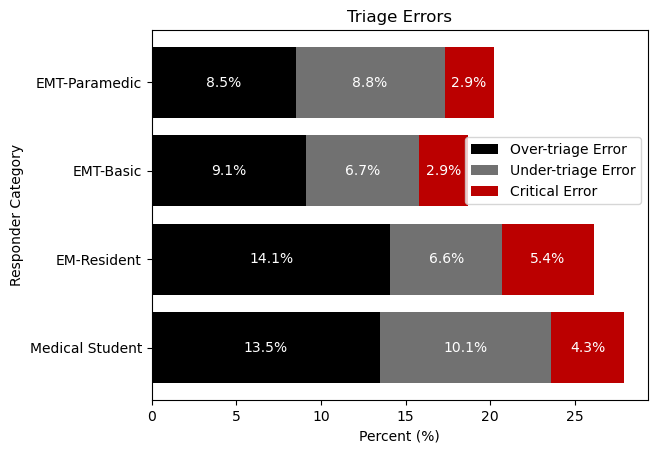

In [33]:

show_stacked_horizontal_bar_chart(triage_error_rates_df, ylabel='Responder Category')


## Please add to the excel data sheet, the triage errors. Please use three separate columns for under, over, and critical.

In [34]:

# Compute error_type, removing "Not Tagged" from consideration
def f(df):
    if df.last_tag in fu.error_table_df.index: error_type = fu.error_table_df[fu.error_table_df.index == df.last_tag][df.max_salt].squeeze()
    else: error_type = np.nan

    return error_type
groupby_columns = ['session_uuid', 'last_tag', 'max_salt', 'responder_category']
anova_error_types_df = tag_to_salt_df.groupby(groupby_columns).patient_count.sum().to_frame().reset_index(drop=False)
anova_error_types_df['error_type'] = anova_error_types_df.apply(f, axis='columns')

# Convert the columns to the custom categorical type
anova_error_types_df['last_tag'] = anova_error_types_df['last_tag'].astype(fu.colors_category_order)
anova_error_types_df['max_salt'] = anova_error_types_df['max_salt'].astype(fu.salt_category_order)
anova_error_types_df['error_type'] = anova_error_types_df['error_type'].astype(fu.errors_category_order)

# Sort the DataFrame based on the custom categorical orders
anova_error_types_df = anova_error_types_df.sort_values(by=groupby_columns+['error_type'])

In [35]:

# Get triage error rates
import re

rows_list = []
for (session_uuid, responder_category), responder_categories_df in anova_error_types_df.groupby(['session_uuid', 'responder_category']):
    row_dict = {'responder_category': responder_category, 'session_uuid': session_uuid}
    df = responder_categories_df.groupby('error_type').patient_count.sum().reset_index(drop=False)
    total_patient_count = df.patient_count.sum()
    error_dict = df.set_index('error_type').patient_count.to_dict()

    over_patient_count = error_dict.get('Over', 0)
    over_triage_error_rate = 100*over_patient_count/total_patient_count
    row_dict['over_triage_error_rate'] = round(over_triage_error_rate, 1)

    under_patient_count = error_dict.get('Under', 0)
    under_triage_error_rate = 100*under_patient_count/total_patient_count
    row_dict['under_triage_error_rate'] = round(under_triage_error_rate, 1)

    critical_patient_count = error_dict.get('Critical', 0)
    critical_triage_error_rate = 100*critical_patient_count/total_patient_count
    row_dict['critical_triage_error_rate'] = round(critical_triage_error_rate, 1)
    
    rows_list.append(row_dict)
anova_error_rates_df = DataFrame(rows_list)

In [36]:

def get_mean_percentage_tag_correct(percentage_tag_correct_df, session_uuid, scene_id, responder_category):
    mean_percentage_tag_correct = 0
    mask_series = (percentage_tag_correct_df.session_uuid == session_uuid) & (percentage_tag_correct_df.scene_id == scene_id)
    mask_series &= (percentage_tag_correct_df.responder_category == responder_category)
    if mask_series.any(): mean_percentage_tag_correct = percentage_tag_correct_df[mask_series].percentage_tag_correct.mean()
    
    return mean_percentage_tag_correct

In [53]:

mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
gb = elevens_df[mask_series].sort_values(['session_uuid']).groupby(['file_name', 'session_file_name', 'session_uuid', 'responder_category', 'encounter_layout'])
rows_list = []
for i, ((file_name, session_file_name, session_uuid, responder_category, encounter_layout), session_df) in enumerate(gb):

    # Get the tuple with the largest percentage correct
    largest_tuple = sorted(
        [(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')],
        key=lambda x: get_mean_percentage_tag_correct(percentage_tag_correct_df, session_uuid, x[2], responder_category)
    )[-1]
    
    responder_categories_df = largest_tuple[0]
    # scene_start = fu.get_scene_start(responder_categories_df)
    row_dict = {
        'ID': f'Responder {i+1}', 'Group': responder_category, 'file_name': file_name, 'session_file_name': session_file_name, 'session_uuid': session_uuid
    }
    row_dict['time_to_triage_scene'] = fu.get_triage_time(responder_categories_df)
    row_dict['time_to_last_hemorrhage_controlled'] = fu.get_time_to_last_hemorrhage_controlled(responder_categories_df)
    
    # Duration of time from when the patient was first approached by the participant until
    # the time hemorrhage treatment was applied (with a tourniquet or wound packing)
    row_dict['time_to_hemorrhage_control_per_patient'] = fu.get_time_to_hemorrhage_control_per_patient(responder_categories_df)
    
    scene_id = largest_tuple[2]
    mask_series = (percentage_tag_correct_df.session_uuid == session_uuid) & (percentage_tag_correct_df.scene_id == scene_id)
    mask_series &= (percentage_tag_correct_df.responder_category == responder_category)
    if mask_series.any():
        row_dict['mean_percentage_tag_correct'] = percentage_tag_correct_df[mask_series].percentage_tag_correct.mean()
        
        # Add the triage errors
        mask_series = (anova_error_rates_df.responder_category == responder_category) & (anova_error_rates_df.session_uuid == session_uuid)
        over_triage_error_rate = anova_error_rates_df[mask_series].over_triage_error_rate.squeeze()
        if not isinstance(over_triage_error_rate, Series): row_dict['over_triage_error_rate'] = over_triage_error_rate
        under_triage_error_rate = anova_error_rates_df[mask_series].under_triage_error_rate.squeeze()
        if not isinstance(under_triage_error_rate, Series): row_dict['under_triage_error_rate'] = under_triage_error_rate
        critical_triage_error_rate = anova_error_rates_df[mask_series].critical_triage_error_rate.squeeze()
        if not isinstance(critical_triage_error_rate, Series): row_dict['critical_triage_error_rate'] = critical_triage_error_rate
    
    row_dict['encounter_layout'] = encounter_layout
    rows_list.append(row_dict)
anova_df = DataFrame(rows_list)

In [62]:

def no_trailing_zero_format(x):
    
    # Handle zero case separately
    if x == 0: return '0'
    
    # Use string formatting for at least 1 digit, no trailing zeros
    return "{:.1f}".format(x)  # Adjust width as needed

# Set formatting function
formatted_srs = anova_df.over_triage_error_rate.to_string(float_format=no_trailing_zero_format)

print(formatted_srs)

AttributeError: 'str' object has no attribute 'drop_duplicates'

In [60]:

anova_df.over_triage_error_rate.to_string?

Signature:
anova_df.over_triage_error_rate.to_string(
    buf=None,
    na_rep='NaN',
    float_format=None,
    header=True,
    index=True,
    length=False,
    dtype=False,
    name=False,
    max_rows=None,
    min_rows=None,
)
Docstring:
Render a string representation of the Series.

Parameters
----------
buf : StringIO-like, optional
    Buffer to write to.
na_rep : str, optional
    String representation of NaN to use, default 'NaN'.
float_format : one-parameter function, optional
    Formatter function to apply to columns' elements if they are
    floats, default None.
header : bool, default True
    Add the Series header (index name).
index : bool, optional
    Add index (row) labels, default True.
length : bool, default False
    Add the Series length.
dtype : bool, default False
    Add the Series dtype.
name : bool, default False
    Add the Series name if not None.
max_rows : int, optional
    Maximum number of rows to show before truncating. If None, show
    all.
min_ro

In [54]:

anova_df.mean_percentage_tag_correct = anova_df.mean_percentage_tag_correct.apply(lambda x: f'{x:.8f}')

In [55]:

anova_df.over_triage_error_rate = anova_df.over_triage_error_rate.apply(lambda x: f'{x:.1g}')

In [56]:

anova_df.critical_triage_error_rate = anova_df.critical_triage_error_rate.apply(lambda x: f'{x:.0g}')

In [57]:

nu.save_data_frames(anova289_df=anova_df)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/anova289_df.csv



----
# Verify

In [46]:

# I just noticed this but can you check responder 6? It seems triage accuracy was not computed (but errors were)
anova_df.iloc[5]

ID                                                                              Responder 6
Group                                                                       Medical Student
file_name                                 First responder master registry v2.0/22.03.15....
session_file_name                                                        22.03.15.1036r.csv
session_uuid                                           aca8a746-0f72-4c8d-87a5-70d836da8768
time_to_triage_scene                                                                 536218
time_to_last_hemorrhage_controlled                                                   370823
time_to_hemorrhage_control_per_patient                                              21033.8
mean_percentage_tag_correct                                                       63.636364
over_triage_error_rate                                                                 18.2
under_triage_error_rate                                                         

In [47]:

# N = 289 and there are 17 people equal to or under 50
# In the file there is 1 value of 0, but in the graph there are appear to be 3
# It seems those 0s are still in the dataset
# I think we should remove these responders and then re-generate
mask_series = (anova_df.mean_percentage_tag_correct == 0)
anova_df[mask_series].T

""
ID
Group
file_name
session_file_name
session_uuid
time_to_triage_scene
time_to_last_hemorrhage_controlled
time_to_hemorrhage_control_per_patient
mean_percentage_tag_correct
over_triage_error_rate


In [78]:

# Figure out who's got less than 50% tag accuracy
mask_series = (percentage_tag_correct_df.percentage_tag_correct < 50)
mask_series = file_stats_df.session_uuid.isin(percentage_tag_correct_df[mask_series].session_uuid)
file_stats_df[mask_series].shape

(19, 19)

In [64]:

# Figure out who's got less than 50% tag accuracy and why
mask_series = (anova_df.mean_percentage_tag_correct < 50.0)
df = anova_df[mask_series]
print(f'There are {df.shape[0]} responders who got less than 50% tag accuracy')
uuids_list = sorted(df.session_uuid)
# mask_series = anova_error_rates_df.session_uuid.isin(uuids_list)
# display(anova_error_rates_df[mask_series])
# mask_series = anova_error_types_df.session_uuid.isin(uuids_list)
# display(anova_error_types_df[mask_series])
mask_series = percentage_tag_correct_df.session_uuid.isin(uuids_list)
file_names_list = []
for session_uuid, session_df in percentage_tag_correct_df[mask_series].groupby('session_uuid'):
    # display(session_df)
    session_mask_series = (elevens_df.session_uuid == session_uuid)
    df = elevens_df[session_mask_series]
    session_file_name = df.session_file_name.unique().tolist()[0]
    file_names_list.append(session_file_name)
    # scene_mask_series = session_mask_series & (elevens_df.scene_id == 0)
    # scene_df = elevens_df[scene_mask_series]
    # patient_count = fu.get_patient_count(scene_df)
    # mask_series = (session_df.predicted_tag != 'Not Tagged')
    # correct_count = session_df[mask_series].correct_count.sum()
    # print(session_file_name, correct_count, '/', patient_count)

There are 17 responders who got less than 50% tag accuracy


In [77]:

# Count the patients in the bad ANOVA rows
file_path = '../saves/txt/bad_robots.txt'
with open(file_path, 'w', encoding=nu.encoding_type) as f: print('', file=f)
mask_series = elevens_df.session_file_name.isin(file_names_list)
columns_list = ['action_tick', 'tag_applied_type', 'patient_id']
for (session_uuid, scene_id), scene_df in elevens_df[mask_series].groupby(fu.scene_groupby_columns):
    patient_count = fu.get_patient_count(scene_df)
    tag_applied_df = scene_df[(scene_df.action_type == 'TAG_APPLIED')]
    session_df = percentage_tag_correct_df[(percentage_tag_correct_df.session_uuid == session_uuid)]
    with open(file_path, mode='a', encoding=nu.encoding_type) as f:
        print('\n', file=f)
        print(
            f'{fu.get_patient_count(scene_df)} patients in {scene_df.session_file_name.unique().squeeze()}'
            f' with {session_df.percentage_tag_correct.mean():.1f}% correctly tagged'
            f' and {tag_applied_df.patient_id.nunique()} out of {patient_count} patients logged as having a TAG_APPLIED', file=f
        )
        print('', file=f)
        tag_to_salt_df[(tag_to_salt_df.session_uuid == session_uuid)].sort_values(['is_tag_correct', 'patient_id']).to_csv(f, index=False, sep='\t')
        print('', file=f)
        tag_applied_df[columns_list].sort_values(['action_tick']).to_csv(f, index=False, sep='\t')

In [66]:

session_uuid = '2d26ca7b-1dbb-42e4-9bbf-bf0d131e2e06'
session_mask_series = (elevens_df.session_uuid == session_uuid)
mask_series = session_mask_series & (elevens_df.scene_id == 0)
scene_df = elevens_df[mask_series]
patient_count = fu.get_patient_count(scene_df)
print(f'{patient_count} patients in the scene')
mask_series = session_mask_series & (elevens_df.action_type == 'TAG_APPLIED')
df = elevens_df[mask_series]
print(f'{df.patient_id.nunique()} patients logged as having a TAG_APPLIED')
# columns_list = df.dropna(axis='columns', how='all').columns.tolist()
columns_list = [
    'action_tick', 'tag_applied_type', 'patient_id'
]
df[columns_list]

11 patients in the scene
7 patients logged as having a TAG_APPLIED


,action_tick,tag_applied_type,patient_id
21278,75385,yellow,Mike_7 Root
21281,77162,yellow,Mike_7 Root
21286,80197,yellow,Lily_4 Root
21292,91616,red,Mike_7 Root
21294,91839,red,Mike_7 Root
21297,94093,yellow,Gloria_6 Root
21304,98272,yellow,Mike_7 Root
21309,101725,yellow,Mike_5 Root
21378,144085,red,Gary_3 Root
21381,146505,red,Gary_3 Root


In [82]:

file_names_list = ['23.07.26.1242.csv', '23.08.08.0748.csv', '23.08.10.0841.csv']


11 patients in 23.08.10.0841.csv with 53.3% correctly tagged and 11 patients logged as having a TAG_APPLIED


,session_uuid,scene_id,predicted_tag,responder_category,correct_count,total_count,percentage_tag_correct
188,0786a1df-d010-4b1b-a99a-e00df486d479,0,black,EMT-Basic,1,1,100.000000
189,0786a1df-d010-4b1b-a99a-e00df486d479,0,gray,EMT-Basic,0,1,0.000000
190,0786a1df-d010-4b1b-a99a-e00df486d479,0,red,EMT-Basic,2,4,50.000000
191,0786a1df-d010-4b1b-a99a-e00df486d479,0,yellow,EMT-Basic,1,2,50.000000
192,0786a1df-d010-4b1b-a99a-e00df486d479,0,green,EMT-Basic,2,3,66.666667



11 patients in 23.07.26.1242.csv with 37.5% correctly tagged and 10 patients logged as having a TAG_APPLIED


,session_uuid,scene_id,predicted_tag,responder_category,correct_count,total_count,percentage_tag_correct
815,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,black,Paramedic,0,1,0.0
816,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,gray,Paramedic,0,1,0.0
817,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,red,Paramedic,3,4,75.0
818,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,yellow,Paramedic,2,2,100.0
819,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,green,Paramedic,1,2,50.0
1466,5c5c9f6e-555c-4ae2-a0c0-7e5eb84a92dd,0,Not Tagged,Paramedic,0,1,0.0



11 patients in 23.08.08.0748.csv with 43.3% correctly tagged and 11 patients logged as having a TAG_APPLIED


,session_uuid,scene_id,predicted_tag,responder_category,correct_count,total_count,percentage_tag_correct
1334,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,black,Paramedic,1,1,100.000000
1335,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,gray,Paramedic,0,1,0.000000
1336,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,red,Paramedic,2,4,50.000000
1337,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,yellow,Paramedic,0,2,0.000000
1338,e8be80d7-4d11-430d-93b7-bc15e1bfb445,0,green,Paramedic,2,3,66.666667


In [27]:

# Show triage accuracy for select sessions
uuids_list = ['84282ed0-0e63-44e0-8b39-5156e3c868d0', '9a6d2f32-10fb-40ea-bacc-dd6a7d2f4a13']
mask_series = file_stats_df.session_uuid.isin(uuids_list)
display(file_stats_df[mask_series].T.sort_index())
mask_series = scene_stats_df.session_uuid.isin(uuids_list)
display(scene_stats_df[mask_series].T.sort_index())

,10,318
encounter_layout,First 11,First 11
file_name,First responder master registry v2.0/22.03.15....,First responder master registry v2.0/23.04.25....
file_start_time,2022-03-15 09:49:00,2023-04-25 10:38:00
file_stop_time,2022-03-15 09:59:00,2023-04-25 10:48:00
global_category,DOC,EMS
global_description,Physicians,Emergency Medical Services
is_a_one_triage_file,False,True
is_in_registry,True,True
logger_version,1.0,1.0
overall_category,Medical Student,EMT-Basic


,221,222,258,259
actual_distracted_delta,8.957749,0.0,0.0,2.906953
actual_engagement_distance,39.341872,0.0,0.0,24.610349
actual_ideal_delta,-1.320745,0.0,0.0,-1.636206
adherence_to_salt,False,False,False,False
cluster_label,0,1,1,0
combo_complexity,0.580348,NaN,NaN,0.635739
combo_entropy,0.933817,NaN,NaN,0.933817
combo_turbulence,9.946762,NaN,NaN,9.936663
distracted_engagement_distance,30.384123,0.0,0.0,21.703396
first_engagement,492116.0,NaN,NaN,261333.0


In [15]:

# Show that the one and only scene in 23.03.03.1023.csv is aborted, which lowers us to 289
uuids_set = set(file_stats_df.session_uuid).difference(set(elevens_df.session_uuid))
mask_series = file_stats_df.session_uuid.isin(uuids_set)
display(file_stats_df[mask_series].T)
mask_series = scene_stats_df.session_uuid.isin(uuids_set)
display(scene_stats_df[mask_series].T)
display(scene_stats_df.patient_count.value_counts())

,96
file_name,First responder master registry v2.0/23.03.03....
logger_version,1.0
session_uuid,e662a811-40fd-4bf2-b9df-d2d221d07b4a
session_file_date,2023-03-03 10:39:00
session_file_name,23.03.03.1023.csv
responder_name,Brian C
responder_type,Paramedic
site_name,Union County
encounter_layout,First 11
file_start_time,2023-03-03 10:23:00


,375
session_uuid,e662a811-40fd-4bf2-b9df-d2d221d07b4a
scene_id,0
last_still_engagement,907198.0
actual_engagement_distance,40.763331
ideal_engagement_distance,41.220091
measure_of_ideal_ordering,0.064207
distracted_engagement_distance,29.710371
measure_of_distracted_ordering,0.282349
measure_of_right_ordering,NaN
actual_ideal_delta,-0.456759


11    279
0      97
1      24
12     13
2       5
13      1
3       1
Name: patient_count, dtype: int64

In [47]:

# Count the patients in the bad ANOVA rows
file_names_list = ['23.03.14.0807.csv', '23.03.14.0827.csv', '23.03.14.0923.csv']
mask_series = elevens_df.session_file_name.isin(file_names_list)
for (session_uuid, scene_id), scene_df in elevens_df[mask_series].groupby(fu.scene_groupby_columns):
    print(session_uuid, scene_id, fu.get_patient_count(scene_df))

8d30008e-c05a-4b2d-8b1c-2e0857985912 0 1
d8e74818-ecc1-4f24-87aa-5dd9facfe20f 0 1
fa155795-d519-45a5-89a4-0ee8c4ea756d 0 1


In [50]:

# Display the session info of the non-11-patient scenes
for (session_uuid, scene_id), scene_df in elevens_df.groupby(fu.scene_groupby_columns):
    patient_count = fu.get_patient_count(scene_df)
    if patient_count != 11: print(session_uuid, scene_id, patient_count, scene_df.session_file_name.unique().squeeze())

8d30008e-c05a-4b2d-8b1c-2e0857985912 0 1 23.03.14.0827.csv
c598ce3a-f613-4d50-8a2f-96cfab35de1c 0 1 23.03.14.0858.csv
d8e74818-ecc1-4f24-87aa-5dd9facfe20f 0 1 23.03.14.0923.csv
fa155795-d519-45a5-89a4-0ee8c4ea756d 0 1 23.03.14.0807.csv


In [ ]:

# 23.07.26.1242.csv	37.5	I get 90.9% accuracy
# 23.08.08.0748.csv	40	I get 90.9% accuracy



----
### Last minute changes

In [3]:

# load data frames
data_frames_dict = nu.load_data_frames(
    anova290_df='', count_swaps_df='',
    verbose=False
)
anova290_df = data_frames_dict['anova290_df']
print('anova290_df', anova290_df.shape[0], anova290_df.session_uuid.nunique(), anova290_df.shape[1]) # 288 288 13
count_swaps_df = data_frames_dict['count_swaps_df']
print('count_swaps_df', count_swaps_df.shape[0], count_swaps_df.session_uuid.nunique(), count_swaps_df.shape[1]) # 289 289 3

anova290_df 288 288 13
count_swaps_df 315 289 3


In [10]:

on_columns = list(set(count_swaps_df.columns).intersection(set(anova290_df.columns)))
print(on_columns)
merge_df = count_swaps_df.merge(anova290_df, on=on_columns, how='inner')
print('merge_df', merge_df.shape[0], merge_df.session_uuid.nunique(), merge_df.shape[1])

['session_uuid']
merge_df 314 288 15


In [11]:

print()
merge_df.swaps_to_perfect_order_count.value_counts().sort_index()

0     79
1    137
2     45
3     47
4      2
5      4
Name: swaps_to_perfect_order_count, dtype: int64

In [12]:

# load data frames
data_frames_dict = nu.load_data_frames(
    first_responder_master_registry_df='', first_responder_master_registry_file_stats_df='', first_responder_master_registry_scene_stats_df='',
    verbose=False
)
triage_paper_df = data_frames_dict['first_responder_master_registry_df']
print('triage_paper_df', triage_paper_df.shape[0], triage_paper_df.session_uuid.nunique(), triage_paper_df.shape[1]) # 367627 290 111
file_stats_df = data_frames_dict['first_responder_master_registry_file_stats_df']
print('file_stats_df', file_stats_df.shape[0], file_stats_df.file_name.nunique(), file_stats_df.shape[1]) # 290 290 19
scene_stats_df = data_frames_dict['first_responder_master_registry_scene_stats_df']
print('scene_stats_df', scene_stats_df.shape[0], scene_stats_df.session_uuid.nunique(), scene_stats_df.shape[1]) # 420 290 48

triage_paper_df 367627 290 111
file_stats_df 290 290 19
scene_stats_df 420 290 48


In [13]:

# Merge only count swaps scenes
patient_count_filter_fn = lambda scene_df: True
elevens_df = fu.get_elevens_data_frame(
    triage_paper_df,
    file_stats_df,
    scene_stats_df,
    needed_columns=[
        'scene_type', 'is_scene_aborted', 'is_a_one_triage_file', 'responder_category', 'responder_type', 'overall_category', 'file_name', 'session_file_name',
        'encounter_layout'
    ],
    patient_count_filter_fn=None
)
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 397230 331 121

elevens_df 365543 289 120


In [14]:

# Get a dataset of only first11 patients
nongrouped_patients_list = nu.load_object('nongrouped_patients_list')
mask_series = ~elevens_df.patient_id.isin(nongrouped_patients_list)
elevens_df = elevens_df[mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 390108 331 121

elevens_df 365521 289 120


In [15]:

# Get a dataset of only "First 11" encounter layouts
mask_series = (elevens_df.encounter_layout == 'DCEMS 11')
display(elevens_df.groupby('encounter_layout').size().to_frame().rename(columns={0: 'record_count'}).sort_values(
    'record_count', ascending=False
).head(5))
elevens_df = elevens_df[~mask_series]
print('elevens_df', elevens_df.shape[0], elevens_df.session_uuid.nunique(), elevens_df.shape[1]) # 367025 295 119

,record_count
encounter_layout,
First 11,365238


elevens_df 365521 289 120


In [18]:

# Get the right swap scene
mask_series = (elevens_df.scene_type == 'Triage') & (elevens_df.is_scene_aborted == False)
gb = elevens_df[mask_series].sort_values(['session_uuid']).groupby(['file_name', 'session_file_name', 'session_uuid', 'responder_category', 'encounter_layout'])
swaps_list = []
for i, ((file_name, session_file_name, session_uuid, responder_category, encounter_layout), session_df) in enumerate(gb):
    largest_tuple = sorted([(scene_df, scene_df.shape[0], scene_id) for scene_id, scene_df in session_df.groupby('scene_id')], key=lambda x: x[1])[-1]
    scene_id = largest_tuple[2]
    mask_series = (count_swaps_df.session_uuid == session_uuid) & (count_swaps_df.scene_id == scene_id)
    swaps_list.append(count_swaps_df[mask_series].swaps_to_perfect_order_count.squeeze())

In [22]:

from pandas import Series

print()
display(Series(swaps_list).value_counts())
print(len(swaps_list))

1    136
0     54
3     47
2     45
5      4
4      2
dtype: int64

288
